In [1]:
# Standard imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Insert path to mavenn beginning of path
import os
import sys
abs_path_to_mavenn = os.path.abspath('../../../')
sys.path.insert(0, abs_path_to_mavenn)

# Load mavenn
import mavenn
print(mavenn.__path__)

['/Users/jkinney/github/mavenn/mavenn']


In [2]:
# Load example data
data_df = mavenn.load_example_dataset('gb1')
data_df.head()

,input_ct,selected_ct,hamming_dist,training_set,y,dy,x
0,1759616.0,3041819.0,0,True,0.000000,0.001366,QYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDD...
1,14663.0,38476.0,1,True,0.602044,0.014001,AYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDD...
2,13001.0,23023.0,1,True,0.034732,0.015827,CYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDD...
3,11488.0,18085.0,1,True,-0.135053,0.017212,DYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDD...
4,9501.0,15629.0,1,True,-0.071659,0.018767,EYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDD...


In [3]:
# Split into trianing and test data
ix = data_df['training_set']
L = len(data_df['x'][0])
train_df = data_df[ix]
print(f'training N: {len(train_df):,}')
test_df = data_df[~ix]
print(f'testing N: {len(test_df):,}')

training N: 429,674
testing N: 107,289


In [4]:
# Set seeed
mavenn.set_seed(0)

# Define model
model = mavenn.Model(regression_type='GE',
                     L=L,
                     alphabet='protein',
                     gpmap_type='additive',                     
                     ge_noise_model_type='Cauchy',
                     ge_heteroskedasticity_order=2)

In [5]:
# Set training data
model.set_data(x=train_df['x'],
               y=train_df['y'])

N = 429,674 observations set as training data.
Data shuffled.
Time to set data: 17.4 sec.


In [6]:
# Fit model to data
history = model.fit(learning_rate=.005,
                    epochs=1000,
                    batch_size=1000,
                    early_stopping=True,
                    early_stopping_patience=10)

 
LSMR            Least-squares solution of  Ax = b

The matrix A has   429674 rows  and     1100 cols
damp = 0.00000000000000e+00

atol = 1.00e-06                 conlim = 1.00e+08

btol = 1.00e-06             maxiter =     1100

 
   itn      x(1)       norm r    norm Ar  compatible   LS      norm A   cond A
     0  0.00000e+00  6.555e+02  6.819e+04   1.0e+00  1.6e-01
     1  1.35584e-02  4.784e+02  5.099e+04   7.3e-01  8.4e-01  1.3e+02  1.0e+00
     2  3.03543e-02  3.705e+02  8.062e+03   5.7e-01  4.7e-03  4.7e+03  1.6e+01
     3  5.05346e-02  2.596e+02  4.464e+03   4.0e-01  3.7e-03  4.7e+03  1.1e+02
     4  6.00529e-02  2.415e+02  1.645e+02   3.7e-01  1.5e-04  4.7e+03  9.0e+01
     5  6.00044e-02  2.415e+02  1.627e+02   3.7e-01  1.4e-04  4.7e+03  9.0e+01
     6  5.96612e-02  2.415e+02  1.486e+02   3.7e-01  9.5e-05  6.5e+03  9.0e+01
     7  5.60233e-02  2.415e+02  1.438e+01   3.7e-01  9.0e-06  6.6e+03  9.0e+01
     8  5.59991e-02  2.415e+02  1.375e+01   3.7e-01  8.6e-06  6.6e+03  9.0

In [7]:
# Save model
model.save('gb1_ge_additive')

Model saved to these files:
	gb1_ge_additive.pickle
	gb1_ge_additive.h5


In [8]:
# Load model
model = mavenn.load('gb1_ge_additive')

Model loaded from these files:
	gb1_ge_additive.pickle
	gb1_ge_additive.h5


In [9]:
# Subsample indices for easy plotting
N_test = len(test_df)
ix = np.random.rand(N_test) < .1

# Get x and y
x = test_df['x'].values[ix]
y = test_df['y'].values[ix]

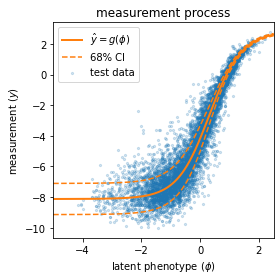

In [10]:
# Compute phi and yhat values
phi = model.x_to_phi(x)
yhat = model.phi_to_yhat(phi)

# Create grid for plotting yhat and yqs
phi_lim = [-5, 2.5]
phi_grid = np.linspace(phi_lim[0], phi_lim[1], 1000)
yhat_grid = model.phi_to_yhat(phi_grid)
yqs_grid = model.yhat_to_yq(yhat_grid, q=[.16,.84])

# Create two panels
fig, ax = plt.subplots(1, 1, figsize=[4, 4])

# Illustrate measurement process with GE curve
ax.scatter(phi, y, color='C0', s=5, alpha=.2, label='test data')
ax.plot(phi_grid, yhat_grid, linewidth=2, color='C1',
        label='$\hat{y} = g(\phi)$')
ax.plot(phi_grid, yqs_grid[:, 0], linestyle='--', color='C1',
        label='68% CI')
ax.plot(phi_grid, yqs_grid[:, 1], linestyle='--', color='C1')
ax.set_xlim(phi_lim)
ax.set_xlabel('latent phenotype ($\phi$)')
ax.set_ylabel('measurement ($y$)')
ax.set_title('measurement process')
ax.legend()

# Fix up plot
fig.tight_layout()
plt.show()

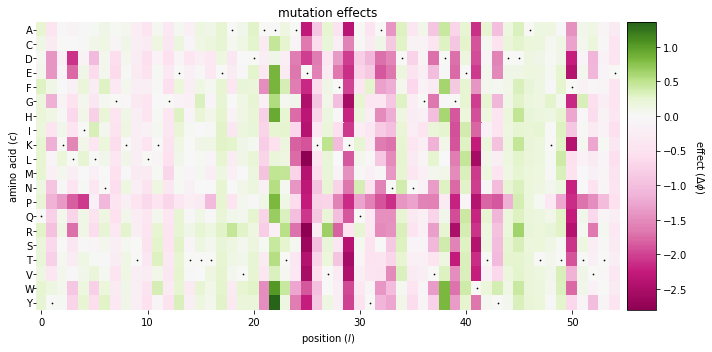

In [11]:
# Set wild-type sequence
gb1_seq = model.x_stats['consensus_seq']

# Get effects of all single-point mutations on phi
theta_dict = model.get_theta(gauge='user',
                             x_wt=gb1_seq)

# Create two panels
fig, ax = plt.subplots(1, 1, figsize=[10, 5])

# Left panel: draw heatmap illustrating 1pt mutation effects
ax, cb = mavenn.heatmap(theta_dict['theta_lc'],
                        alphabet=theta_dict['alphabet'],
                        seq=gb1_seq,
                        cmap='PiYG',
                        ccenter=0,
                        ax=ax)
ax.set_xlabel('position ($l$)')
ax.set_ylabel('amino acid ($c$)')
cb.set_label('effect ($\Delta\phi$)', rotation=-90, va="bottom")
ax.set_title('mutation effects')

# Fix up plot
fig.tight_layout()
plt.show()
